# Fine-Tuning Transformers

## The dataset

* **Gotcha**: We can use `list_datasets` to see the data available on huggingface hub.
* **Gotcha**: The dataset structure it's one of the most important concepts in Huggingface.
* **Huh**: Why this from `datasets import list_datasets` doesnt work?
* **Huh**: This reflects the fact that Datasets is
based on Apache Arrow, which defines a typed columnar format that is more memory
efficient than native Python

If you can't find your dataset at HuggingFace, you can acess you data as show in Figura 1.

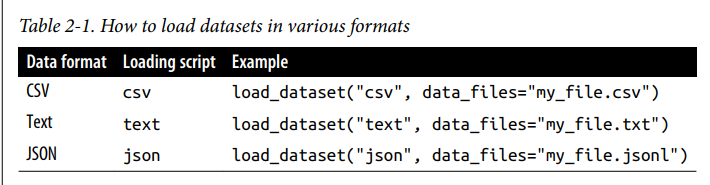

Figura 1 | How upload a personal dataset.

## From Datasets to Dataframes

* **Gotcha**: use `emotions.reset_format() ` to reset from dataframe to dataset.

# Code

In [1]:
%%capture
!pip install datasets

In [2]:
## List Of
## datasets on
## hugging face

# from datasets import list_datasets
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
## Acessing a specific
## split
val_ds = emotions['train']
test_ds = emotions['test']
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
## Acessing a single
## exemple

train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
## Get Columns names
train_ds.column_names

['text', 'label']

In [6]:
## Acessing data types
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
## Convert DataSet
## To Dataframe

import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
## add label_name
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


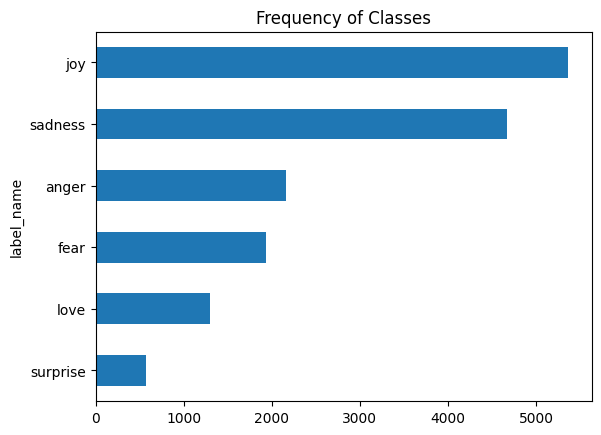

In [9]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [10]:
emotions.reset_format()

In [11]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## From Text to Tokens

### Subword Tokenization
* **Aha**: Subworkd combine caracter and word tokenization.

In [12]:
from transformers import AutoTokenizer
model_ckpt = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Tokenizing the Whole Dataset

In [13]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded['train']

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16000
})

##Training a Text Classifier

In [15]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Extract Hide State

In [18]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    # Extract last hidden states

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [19]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Feature Matrix

In [20]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing

In [22]:
# from umap import UMAP
# from sklearn.preprocessing import MinMaxScaler
# # Scale features to [0,1] range
# X_scaled = MinMaxScaler().fit_transform(X_train)
# # Initialize and fit UMAP
# mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# # Create a DataFrame of 2D embeddings
# df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
# df_emb["label"] = y_train
# df_emb.head()

In [23]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5965

In [24]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5965

In [26]:
# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds, normalize="true")
#     fig, ax = plt.subplots(figsize=(6, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
#     plt.title("Normalized confusion matrix")
#     plt.show()

# y_preds = lr_clf.predict(X_valid)
# plot_confusion_matrix(y_preds, y_valid, labels)